# Fitting old pipelines to new data

In this brief notebook, you'll see how to load a saved pipeline and fit it to raw data again.  This is a very useful way to retrain a classifier to new data (which you might do after observing data drift) or to change the hyperparameters you used while training the classifier.  

Machine learning pipelines work in two ways:  for training, they allow you to precisely specify a sequence of steps (data cleaning, feature extraction, dimensionality reduction, model training, etc.) that start with raw data and result in a model, trying this sequence with different hyperparameters.  For production, they allow you to reuse the exact sequence of steps that were used in training a model to make predictions from new raw data. 

We'll start by loading training and testing data:

In [1]:
import pandas as pd
from sklearn import model_selection
df = pd.read_parquet("data/training.parquet")

# X_train and X_test are lists of strings, each 
# representing one document
# y_train and y_test are vectors of labels

train, test = model_selection.train_test_split(df, random_state=43)
X_train = train["text"]
y_train = train["label"]

X_test = test["text"]
y_test = test["label"]

/Users/willb/anaconda/envs/rhte-jupyter/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/willb/anaconda/envs/rhte-jupyter/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/willb/anaconda/envs/rhte-jupyter/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Next up, we'll load the two steps of the pipeline that we created in earlier notebooks:

- `feature_pipeline.sav` from either the [simple summaries notebook](03-feature-engineering-summaries.ipynb) or the [TF-IDF notebook](03-feature-engineering-tfidf.ipynb), and
- `model.sav` from either the [logistic regression notebook](04-model-logistic-regression.ipynb) or the [random forest notebook](04-model-random-forest.ipynb).

(If you haven't worked through a feature engineering notebook and a model training notebook, the next cell won't work.)

In [2]:
## loading in feature extraction pipeline
import pickle
filename = 'feature_pipeline.sav'
feat_pipeline = pickle.load(open(filename, 'rb'))

## loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

Now we can combine the two stages together in a pipeline and fit it to new training data.  (Note that the feature extraction pipeline stage, `feature_pipeline.sav`, is *itself* a pipeline!)

In [3]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('features',feat_pipeline),
    ('model',model)
])

A pipeline supports the same interface as a classifier, so we can use it to `fit` to raw data and then `predict` labels from raw data:

In [4]:
pipeline.fit(X_train,y_train)
y_preds = pipeline.predict(X_test)

We can then evaluate the performance of our classifier, using a confusion matrix:

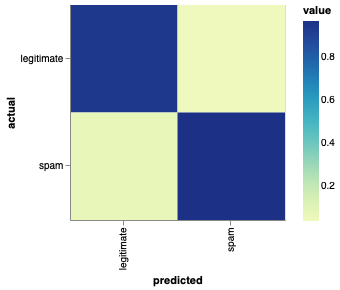

In [5]:
from mlworkflows import plot
_, chart = plot.binary_confusion_matrix(y_test, y_preds)
chart

...or an F<sub>1</sub>-score:

In [6]:
from sklearn.metrics import f1_score
# calculate f1 score
mean_f1 = f1_score(y_test, y_preds, average='micro')
print(mean_f1)

0.9509


The [scikit-learn pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) doesn't just make a particular pipeline repeatable; it also lets you run repeatable experiments by evaluating the same pipeline with different hyperparameters for the same data set.  To see this in action, we'll inspect the pipeline stages to see their hyperparameters:

In [7]:
pipeline.named_steps

{'features': Pipeline(memory=None,
          steps=[('vect',
                  HashingVectorizer(alternate_sign=True, analyzer='word',
                                    binary=False, decode_error='strict',
                                    dtype=<class 'numpy.float64'>,
                                    encoding='utf-8', input='content',
                                    lowercase=True, n_features=1024,
                                    ngram_range=(1, 1), norm=None,
                                    preprocessor=None, stop_words=None,
                                    strip_accents=None,
                                    token_pattern='(?u)\\b[A-Za-z]\\w+\\b',
                                    tokenizer=None)),
                 ('tfidf',
                  TfidfTransformer(norm='l2', smooth_idf=True,
                                   sublinear_tf=False, use_idf=True))],
          verbose=False),
 'model': RandomForestClassifier(bootstrap=True, class_weight=None, crit

Let's experiment with a couple of different options for a hyperparameter.  Since we have no way of knowing while we're writing this notebook whether you trained a logistic regression model or a random forest model, this notebook will try and figure it out on the fly (since these model types have different hyperparameters).  The [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) class in scikit-learn allows us to evaluate different combinations of hyperparameters; we'll use it with just a few options to quickly demonstrate its functionality.

Since this can be an expensive operation, we'll also time it to see how long it takes.

In [8]:
%%time

from sklearn.model_selection import GridSearchCV

search = None
param_grid = {}

small_train, small_test = model_selection.train_test_split(df.sample(5000), random_state=43)

if 'LogisticRegression' in str(pipeline.named_steps['model']):
    # we're dealing with a logistic regression model
    param_grid = { 'model__multi_class' : ['ovr', 'multinomial'], 'model__solver' : ['lbfgs', 'newton-cg']}
else:
    # we're dealing with a random forest model
    param_grid = { 'model__min_samples_split' : [2, 8], 
                   'model__n_estimators' : [10, 25, 50, 100], 
                   'model__criterion' : ['gini', 'entropy']}

search = GridSearchCV(pipeline, param_grid, iid=False, cv=3, return_train_score=False)
search.fit(small_train["text"], small_train["label"])

print("Best parameters were %s" % str(search.best_params_))

Best parameters were {'model__criterion': 'entropy', 'model__min_samples_split': 8, 'model__n_estimators': 100}
CPU times: user 38.1 s, sys: 326 ms, total: 38.5 s
Wall time: 39.3 s


`GridSearchCV` evaluates every hyperparameter combination from the supplied lists of values.  So in the random forest case above, we'd consider the following hyperparameter mappings:

- `multiclass == 'ovr'` and `solver == 'lbgfs'`,
- `multiclass == 'ovr'` and `solver == 'newton-cg'`,
- `multiclass == 'multinomial'` and `solver == 'lbgfs'`, and
- `multiclass == 'multinomial'` and `solver == 'newton-cg'`.

In our example, [we divide the training set into three subsets, or _folds_, instead of using train and test sets](https://en.wikipedia.org/wiki/Cross-validation_(statistics)):  if we call the three subsets $a$, $b$, and $c$, we'll be 

- training against $a \cup b$ and testing against $c$,
- training against $a \cup c$ and testing against $b$, and
- training against $b \cup c$ and testing against $a$

for each hyperparameter combination before averaging the results of each test.  Since we will train $k - 1$ models for $k$-fold validation, and since we'll validate every possible combination of hyperparameters, grid search can get computationally expensive very quickly.  (If you were using grid search in a real application, you'd have more time than we do during this workshop, so you'd probably use more folds for cross-validation and also probably be working with a larger sample count.)

One option for making grid search faster is to run individual experiments in parallel.  We'll look at one now:  [Dask](https://dask.org) provides scale-out versions of many features in scikit-learn and Pandas so that you can run machine learning pipelines in parallel across multiple threads or multiple containers.  We'll look at a simple version -- using threads -- now.

In [9]:
%%time

from dask.ml_model_selection import GridSearchCV

search = None
param_grid = {}

small_train, small_test = model_selection.train_test_split(df.sample(5000), random_state=43)

if 'LogisticRegression' in str(pipeline.named_steps['model']):
    # we're dealing with a logistic regression model
    param_grid = { 'model__multi_class' : ['ovr', 'multinomial'], 'model__solver' : ['lbfgs', 'newton-cg']}
else:
    # we're dealing with a random forest model
    param_grid = { 'model__min_samples_split' : [2, 8], 
                   'model__n_estimators' : [10, 25, 50, 100], 
                   'model__criterion' : ['gini', 'entropy']}

search = GridSearchCV(pipeline, param_grid, iid=False, cv=3, return_train_score=False)
search.fit(small_train["text"], small_train["label"])

print("Best parameters were %s" % str(search.best_params_))

ModuleNotFoundError: No module named 'dask'

# Exercises


Later in this session, we'll see how pipeline abstractions can make it easier not just to experiment with variations on techniques, but also to put machine learning into production.  For now, here are some things to try out and think about.

1.  Identify some ways in which machine learning pipelines are like CI/CD pipelines and some ways in which they're different.
2.  Experiment with values for some different hyperparameters in the text classification pipeline.
3.  Even if you aren't overfitting, you might not want to choose the absolute best-performing hyperparameter settings.  What are some cases in which you might not?
4.  What are some considerations that grid search might not capture?